### ДЗ 6. Градиентный бустинг (AdaBoost)

Используя файл Lesson_6_extended.ipynb (он в web6.zip в материалах):

Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

*Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

*Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [14]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге

In [6]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).



In [8]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.


In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

#### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [21]:
# 1) график зависимости ошибки от максимальной глубины деревьев

In [12]:
eta = 0.5
max_depths = range(1, 10)

def plot_max_depths(n_trees=n_trees, max_depths=max_depths):
    train_err_depths = []
    test_err_depths = []

    for max_depth in tqdm(max_depths):
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_err_depths.append(train_errors[-1])
        test_err_depths.append(test_errors[-1])


    print(f'Количество деревьев в бустинге: {n_trees}')
    plt.plot(range(len(max_depths)), train_err_depths, label='train_err_depths', color = 'r')
    plt.plot(range(len(max_depths)), test_err_depths, label='test_err_depths', color = 'b')
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.69it/s]


Количество деревьев в бустинге: 3


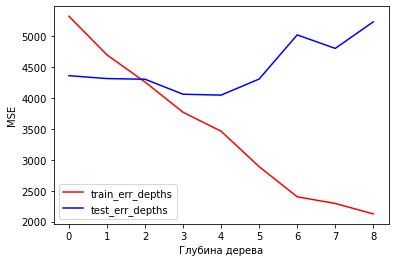

In [15]:
plot_max_depths(n_trees=3, max_depths=max_depths)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.15it/s]

Количество деревьев в бустинге: 5


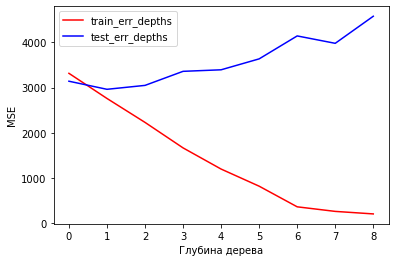

In [16]:
plot_max_depths(n_trees=5, max_depths=max_depths)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.05s/it]

Количество деревьев в бустинге: 10


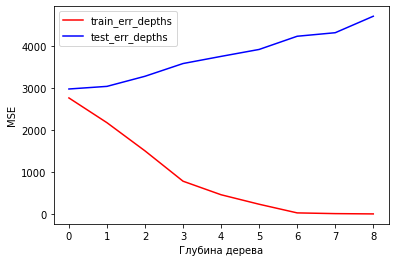

In [17]:
plot_max_depths(n_trees=10, max_depths=max_depths)

#### При увеличении глубины дерева модель переобучается при любом количестве деревьев

In [22]:
# 2) график зависимости ошибки от количества деревьев в ансамбле

In [27]:
eta = 0.5
n_trees = range(1, 30, 5)


def plot_trees(n_trees, max_depth):
    train_err_trees = []
    test_err_trees = []

    for n_tree in tqdm(n_trees):
        _, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, eta)
        train_err_trees.append(train_errors[-1])
        test_err_trees.append(test_errors[-1])


    print(f'Глубина дерева {max_depth}')
    plt.plot(range(len(n_trees)), train_err_trees, label='train_err_trees', color = 'r')
    plt.plot(range(len(n_trees)), test_err_trees, label='test_err_trees', color = 'g')
    plt.xlabel('Trees')
    plt.ylabel('MSE')
    plt.legend()

In [28]:
list(n_trees)

[1, 6, 11, 16, 21, 26]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.46s/it]

Глубина дерева 3


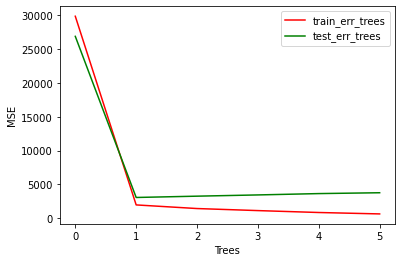

In [29]:
plot_trees(n_trees=n_trees, max_depth=3)

#### При увеличении количества деревьев в ансамбле модель переобучается не так сильно